#  XGB Model

In [2]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from joblib import dump, load  # for saving models

In [483]:
%reload_ext autoreload
from automl import *

In [396]:
import gc
import GPUtil

In [5]:
# MANIFEST - list of versions on board 
print_manifest()

2020-02-24 13:56:26.762955
OS: Linux
Python: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
matplotlib: 3.1.3
numpy: 1.18.1
pandas: 1.0.1
sklearn: 0.22.1
xgboost: 0.90


/home/user/mortality/omop-cdm-postgresql/automl.py:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  print(pd.datetime.now())


In [6]:
# https://askubuntu.com/questions/5417/how-to-get-the-gpu-info
# might want to conditinally set the 'tree_method' parameter to xbgoost based on the return to this call
! lspci  -v -s  $(lspci | grep ' VGA ' | cut -d" " -f 1) | grep 'controller'

01:00.0 VGA compatible controller: NVIDIA Corporation GP102 [GeForce GTX 1080 Ti] (rev a1) (prog-if 00 [VGA controller])


## Data Prep

In [335]:
OUR_NA = -999  # could be better than 0 for XGB

In [407]:
FOLDER = '../mortality_prediction_docker_model/v2/scratch_friday0/'
# train_file = FOLDER+'train_death_last.csv.gz'
train_file = FOLDER+'train_all.csv.gz'

train = pd.read_csv(train_file, low_memory=False)
train.shape

(97916, 208)

In [408]:
train.head()

,race_concept_id,death_in_next_window,number_of_visits,old,gender_concept_id,race_concept_name,visit_concept_name,visit_duration,person_id,ethnicity_concept_id,...,observation_concept_id_list_2617939,observation_concept_id_list_4015724,observation_concept_id_list_40663262,observation_concept_id_list_4214956,observation_concept_id_list_432507,observation_concept_id_list_434237,observation_concept_id_list_439615,observation_concept_id_list_440927,observation_concept_id_list_442941,observation_type_concept_id_list_38000282
0,8552.0,0,2,87.0,8507,Unknown,1,0,0,NaN,...,0,1,0,0,0,0,0,1,0,1
1,8557.0,0,6,75.0,8507,Native Hawaiian or Other Pacific Islander,2,0,5,NaN,...,0,0,0,0,0,0,0,0,0,0
2,8527.0,0,4,34.0,8532,White,1,1,6,NaN,...,0,1,0,1,0,0,0,1,0,1
3,8657.0,0,1,72.0,8532,American Indian or Alaska Native,0,0,7,38003564.0,...,0,0,0,0,0,0,0,0,0,0
4,8657.0,0,1,76.0,8532,American Indian or Alaska Native,0,0,8,38003564.0,...,0,0,0,0,0,0,0,0,0,0


In [338]:
max_non_concept = 19 # set this to the column # prior to concepts column names
cols = pd.DataFrame([[c.split('_')[-1] for c in train.columns],train.columns]).T
cols.columns =['concept_id','column']
cols.concept_id[0:max_non_concept] = 0 # the first are strings
cols.concept_id = cols.concept_id.astype(int)
cols.iloc[max_non_concept-1:max_non_concept+5]

,concept_id,column
18,0,days_since_latest_observation
19,135939,condition_concept_id_list_135939
20,140673,condition_concept_id_list_140673
21,192273,condition_concept_id_list_192273
22,193249,condition_concept_id_list_193249
23,193308,condition_concept_id_list_193308


In [339]:
all_concepts = pd.read_csv('v2/app/concept_codes_final/all_concepts.csv')
all_concepts.head()

,concept_id,concept_name,vocabulary_id,table
0,3000453,Epstein Barr virus DNA [#/volume] (viral load)...,LOINC,measurement
1,3000515,Antithrombin actual/normal in Platelet poor pl...,LOINC,measurement
2,3000722,Carnitine free (C0) [Moles/volume] in Serum or...,LOINC,measurement
3,3001405,CD3+CD8+ (T8 suppressor cells) cells [#/volume...,LOINC,measurement
4,3001599,Carotene [Mass/volume] in Serum,LOINC,measurement


In [340]:
col_concepts = cols.set_index('concept_id').join(all_concepts.set_index('concept_id'), how='left')
col_concepts.head()

,column,concept_name,vocabulary_id,table
concept_id,,,,
0,race_concept_id,NaN,NaN,NaN
0,death_in_next_window,NaN,NaN,NaN
0,number_of_visits,NaN,NaN,NaN
0,old,NaN,NaN,NaN
0,gender_concept_id,NaN,NaN,NaN


In [341]:
col_concepts.tail()

,column,concept_name,vocabulary_id,table
concept_id,,,,
40664421,procedure_concept_id_list_40664421,NaN,NaN,NaN
42708698,drug_concept_id_list_42708698,NaN,NaN,NaN
42709184,drug_concept_id_list_42709184,NaN,NaN,NaN
42901904,drug_concept_id_list_42901904,NaN,NaN,NaN
46287422,drug_concept_id_list_46287422,NaN,NaN,NaN


In [342]:
# What % oc concept_id's don't have a corresponding concept code?
round(col_concepts.isnull().sum().table / col_concepts.shape[0], 2)*100

74.0

In [343]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train.race_concept_name = train.race_concept_name.replace(to_replace=OUR_NA, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [344]:
from sklearn.preprocessing import LabelEncoder

categoricals = ['ethnicity_concept_id',
               'gender_concept_id',
               'race_concept_id',
               'condition_status_concept_id',
               'race_concept_name']

for c in categoricals:
    le = LabelEncoder()
    train[c]=le.fit_transform(train[c])

In [345]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 155.38 MB


In [346]:
train = train.fillna(OUR_NA)
train = cols_toint(train)

In [347]:
%%time
train = reduce_mem_usage(train)

Memory usage of dataframe is 155.38 MB
Memory usage after optimization is: 21.20 MB
Decreased by 86.4%
CPU times: user 1.78 s, sys: 896 ms, total: 2.68 s
Wall time: 2.68 s


In [348]:
train.head()

,race_concept_id,death_in_next_window,number_of_visits,old,gender_concept_id,race_concept_name,visit_concept_name,visit_duration,person_id,ethnicity_concept_id,...,observation_concept_id_list_2617939,observation_concept_id_list_4015724,observation_concept_id_list_40663262,observation_concept_id_list_4214956,observation_concept_id_list_432507,observation_concept_id_list_434237,observation_concept_id_list_439615,observation_concept_id_list_440927,observation_concept_id_list_442941,observation_type_concept_id_list_38000282
0,3,False,2,87,False,4,1,0,0,13149,...,False,True,False,False,False,False,False,True,False,True
1,4,False,6,75,False,3,2,0,5,23132,...,False,False,False,False,False,False,False,False,False,False
2,2,False,4,34,True,5,1,1,6,23133,...,False,True,False,True,False,False,False,True,False,True
3,5,False,1,72,True,0,0,0,7,1,...,False,False,False,False,False,False,False,False,False,False
4,5,False,1,76,True,0,0,0,8,1,...,False,False,False,False,False,False,False,False,False,False


In [349]:
# %%time
# # expensive, don't do this if you don't have time
# find_dup_cols(train)

In [350]:
# # there are no duplicates
# train_nodup = train.drop_duplicates()
# train_nodup.shape

In [351]:
train_describe_df = train[:30].describe(include='all').T.fillna('')
train_describe_df[:30]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race_concept_id,30.0,,,,63.0333,187.834,0,2,3,4,778
death_in_next_window,30.0,1,False,30,,,,,,,
number_of_visits,30.0,,,,2.3,1.62205,1,1,2,3,7
old,30.0,,,,74.2333,11.3188,34,69,75.5,78,97
gender_concept_id,30.0,2,False,16,,,,,,,
race_concept_name,30.0,,,,3,1.57568,0,2,3.5,4,5
visit_concept_name,30.0,,,,0.433333,0.727932,0,0,0,1,3
visit_duration,30.0,,,,0.1,0.402578,0,0,0,0,2
person_id,30.0,,,,25.8333,15.1181,0,12.25,25.5,40.25,49
ethnicity_concept_id,30.0,,,,10465.3,11517.6,1,1,1,23136.8,23144


In [352]:
train.shape

(97916, 208)

In [383]:
# select features
drop_features = ['death_in_next_window', 'window_id','person_id']
drop_features = ['death_in_next_window', 'person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

## Test 

In [354]:
test_file = FOLDER+'test_all_target.csv.gz'
test = pd.read_csv(test_file,low_memory = False)
test.shape

FileNotFoundError: [Errno 2] No such file or directory: '../mortality_prediction_docker_model/v2/scratch_friday0/test_all_target.csv.gz'

In [59]:
test = cols_toint(test)
test.shape

(118781, 232)

In [60]:
test.race_concept_name = test.race_concept_name.replace(to_replace=0, value='Unknown')
test.race_concept_name = test.race_concept_name.fillna('Unknown')
test.race_concept_name = label_encoder.transform(test.race_concept_name)

In [104]:
X_test = test.drop(drop_features, axis = 1)
X_test = X_test[train_features]  # order the test columns like train
test_features = X_test.columns.values
X_test = np.array(X_test)

In [106]:
y_test = test.death_in_next_window
X_test.shape, y_test.shape

((118781, 229), (118781,))

## Feature Selection

In [249]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [261]:
# from sklearn.model_selection import StratifiedShuffleSplit

# #from sklearn.model_selection import train_test_split
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

# for train_index, valid_index in sss.split(X, y):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

In [262]:
%%time
clf_et = ExtraTreesClassifier(n_estimators=500, max_depth=40, random_state=random_state)
clf_et = clf.fit(X, y)

(18191, 11921) (18191,)
CPU times: user 1min 29s, sys: 44 ms, total: 1min 29s
Wall time: 1min 29s


In [263]:
ET_feat_importance = pd.DataFrame([train_features, clf_et.feature_importances_]).T
ET_feat_importance.columns = ['feature','importance']
ET_feat_importance = ET_feat_importance.sort_values(by='importance', ascending=False)
ET_feat_importance.head(20)

,feature,importance
3,number_of_visits,0.0197456
1,visit_concept_name,0.0125517
10,outpatient_visit_count,0.0103247
8686,drug_concept_id_list_19019626,0.0101682
7,old,0.006326
12,total_quantity_of_drugs,0.00571369
4634,procedure_concept_id_list_2001510,0.00545314
8625,drug_concept_id_list_19018901,0.00544711
8920,drug_concept_id_list_19048000,0.00541019
6290,procedure_concept_id_list_2106033,0.00534228


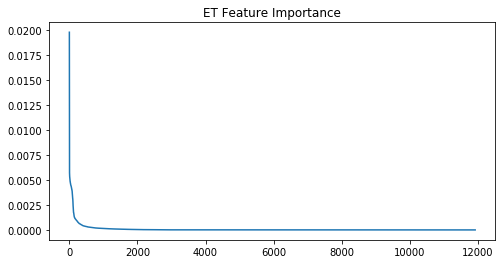

In [264]:
ax=ET_feat_importance.importance.plot(use_index=False, figsize=(8,4), title='ET Feature Importance')

In [265]:
(ET_feat_importance.importance > 0.001).sum()

200

In [266]:
%%time
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=40,  random_state=random_state,)
clf_rf = clf.fit(X, y)

CPU times: user 1min 28s, sys: 40 ms, total: 1min 28s
Wall time: 1min 28s


In [267]:
RF_feat_importance = pd.DataFrame([train_features, clf_rf.feature_importances_]).T
RF_feat_importance.columns = ['feature','importance']
RF_feat_importance = RF_feat_importance.sort_values(by='importance', ascending=False)
RF_feat_importance.head(20)

,feature,importance
3,number_of_visits,0.0189775
10,outpatient_visit_count,0.0120984
8686,drug_concept_id_list_19019626,0.0115855
1,visit_concept_name,0.011547
12,total_quantity_of_drugs,0.00631756
7,old,0.00613483
4634,procedure_concept_id_list_2001510,0.00574478
6,race_concept_id,0.0053868
424,condition_concept_id_list_193308,0.00536428
9388,drug_concept_id_list_19122875,0.00524866


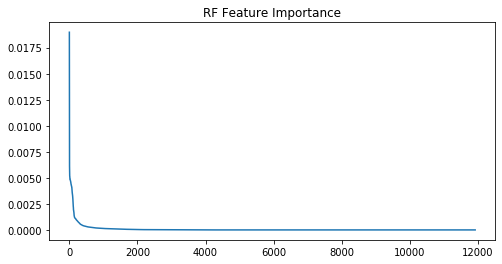

In [268]:
ax=RF_feat_importance.importance.plot(use_index=False, figsize=(8,4), title='RF Feature Importance')

In [269]:
(RF_feat_importance.importance > 0.001).sum()

198

In [275]:
ET_feat_importance.head()

,feature,importance
3,number_of_visits,0.0197456
1,visit_concept_name,0.0125517
10,outpatient_visit_count,0.0103247
8686,drug_concept_id_list_19019626,0.0101682
7,old,0.006326


In [278]:
inET = list(set(ET_feat_importance.iloc[:210].index) - set(RF_feat_importance.iloc[:210].index))
ET_feat_importance.loc[inET].sort_values(by='importance', ascending=False)

,feature,importance
11232,drug_concept_id_list_938045,0.00132154
7630,procedure_concept_id_list_2314290,0.00114595
8511,drug_concept_id_list_1742258,0.001112
10814,drug_concept_id_list_42708698,0.00109642
7679,procedure_concept_id_list_2414395,0.00106649
3881,condition_concept_id_list_75637,0.00106336
4867,procedure_concept_id_list_2003090,0.00104316
6277,procedure_concept_id_list_2105956,0.00103364
8031,procedure_type_concept_id_list_38000251,0.00102705
7764,procedure_concept_id_list_2617177,0.00102002


In [280]:
inRF = list(set(RF_feat_importance.iloc[:210].index) - set(ET_feat_importance.iloc[:210].index))
RF_feat_importance.loc[inRF].sort_values(by='importance', ascending=False)

,feature,importance
75,condition_concept_id_list_133697,0.00125315
9966,drug_concept_id_list_40168604,0.00121321
3893,condition_concept_id_list_75900,0.00120535
5828,procedure_concept_id_list_2101659,0.00119505
11188,drug_concept_id_list_917310,0.00115739
5618,procedure_concept_id_list_2007830,0.00113427
389,condition_concept_id_list_192671,0.00112068
2701,condition_concept_id_list_435784,0.00110087
7317,procedure_concept_id_list_2213601,0.00109428
4495,procedure_concept_id_list_2001198,0.00107115


In [281]:
model = SelectFromModel(clf, prefit=True, max_features=200, threshold='median')
X_new = model.transform(X)
X_new.shape               

(18191, 200)

In [287]:
top_features = ET_feat_importance[ET_feat_importance.importance > 0.001].feature.to_list()

In [288]:
top_features = [f.replace('id_list_','') for f in top_features]

In [291]:
top_file= open("top_features.txt","w+")
for line in top_features:
    top_file.write(line)
top_file.close()

In [295]:
!ls top_features.txt; ls features.txt

top_features.txt
features.txt


In [299]:
orig_features = [line.rstrip('\n') for line in open('features.txt')]

In [303]:
print(len(top_features), len(orig_features))
len(set(top_features) - set(orig_features))

200 247


183

## Load Selected Features

In [76]:
train_file = FOLDER+'train_all.csv.gz'
train = pd.read_csv(train_file,low_memory = False)
train.shape

(278998, 232)

In [77]:
train.head()

,days_since_latest_visit,death_in_next_window,person_id,visit_duration,number_of_visits,race_concept_name,race_concept_id,old,visit_concept_name,gender_concept_id,...,observation_concept_id_list_40757059,observation_concept_id_list_4081756,observation_concept_id_list_4176605,observation_concept_id_list_4186037,observation_concept_id_list_4192270,observation_concept_id_list_4214956,observation_concept_id_list_43021378,observation_concept_id_list_4305831,observation_concept_id_list_433942,observation_type_concept_id_list_38000282
0,45,0,0,0,4,Unknown,8552.0,84.0,0,8507,...,0,0,0,0,0,1,0,0,0,1
1,31,0,5,0,1,Native Hawaiian or Other Pacific Islander,8557.0,72.0,1,8507,...,0,0,0,0,0,0,0,0,0,0
2,103,0,6,0,3,White,8527.0,31.0,0,8532,...,0,0,0,0,0,0,0,0,0,1
3,84,0,10,0,1,Unknown,8552.0,71.0,0,8532,...,0,0,0,0,0,0,0,0,0,0
4,2,0,12,0,2,Black or African American,8516.0,88.0,0,8532,...,0,0,0,0,0,0,0,0,0,0


In [78]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train.race_concept_name = train.race_concept_name.replace(to_replace=OUR_NA, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [79]:
from sklearn.preprocessing import LabelEncoder

categoricals = ['ethnicity_concept_id',
               'gender_concept_id',
               'race_concept_id',
               'condition_status_concept_id',
               'race_concept_name']

for c in categoricals:
    le = LabelEncoder()
    train[c]=le.fit_transform(train[c])

In [80]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 493.83 MB


In [81]:
train = train.fillna(OUR_NA)
train = cols_toint(train)

In [82]:
%%time
train = reduce_mem_usage(train)

Memory usage of dataframe is 493.83 MB
Memory usage after optimization is: 67.58 MB
Decreased by 86.3%
CPU times: user 4.99 s, sys: 3.23 s, total: 8.22 s
Wall time: 8.22 s


In [37]:
train.head()

,race_concept_id,death_in_next_window,number_of_visits,old,gender_concept_id,race_concept_name,visit_concept_name,visit_duration,person_id,ethnicity_concept_id,...,observation_concept_id_list_2617939,observation_concept_id_list_4015724,observation_concept_id_list_40663262,observation_concept_id_list_4214956,observation_concept_id_list_432507,observation_concept_id_list_434237,observation_concept_id_list_439615,observation_concept_id_list_440927,observation_concept_id_list_442941,observation_type_concept_id_list_38000282
0,3,False,2,87,False,4,1,0,0,13149,...,False,True,False,False,False,False,False,True,False,True
1,4,False,6,75,False,3,2,0,5,23132,...,False,False,False,False,False,False,False,False,False,False
2,2,False,4,34,True,5,1,1,6,23133,...,False,True,False,True,False,False,False,True,False,True
3,5,False,1,72,True,0,0,0,7,1,...,False,False,False,False,False,False,False,False,False,False
4,5,False,1,76,True,0,0,0,8,1,...,False,False,False,False,False,False,False,False,False,False


## XGB Model

In [114]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 3,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 500,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 10,
#    'num_parallel_tree' : 1,   # for RF
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': OUR_NA,
}

In [86]:
# %%time
drop_features = ['death_in_next_window', 'window_id', 'person_id']
window = {}
xgb_model = None # clear out the xgb_model
for w in train.window_id.unique():
    X = train[train.window_id == w] #[train.columns[:50]].copy()
    y = train[train.window_id == w].death_in_next_window
    window[w] = {'size': y.shape[0], 'deaths': y.sum()}
    X = X.drop(drop_features, axis=1)
    train_features = X.columns.values
    X = np.array(X)
    y = np.array(y).ravel()
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    cv_scores = {}
    for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        evals_result ={}
        # Convert our data into XGBoost format
        d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
        d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                              evals=watchlist, evals_result=evals_result, 
                              early_stopping_rounds=early_stop, verbose_eval=False,
                              xgb_model= xgb_model,
                              callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
                                         # plot_perf_i(evals_result)]) 
        cv_scores[i] = {'best_score': xgb_model.best_score, 
                        'best_iteration': xgb_model.best_iteration, 
                        'best_ntree_limit': xgb_model.best_ntree_limit,
                        'evals_result': evals_result}

        print("Best Score:%f, best iteration:%d, best ntree:%d" % 
              (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))
        window[w].update(cv_scores)
        # GPUtil.showUtilization()
        gc.collect()

Best Score:0.589139, best iteration:93, best ntree:94



Best Score:0.641125, best iteration:3, best ntree:4


Best Score:0.641125, best iteration:3, best ntree:4



Best Score:0.681672, best iteration:16, best ntree:17



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



Best Score:0.734104, best iteration:102, best ntree:103


Best Score:0.734104, best iteration:102, best ntree:103



In [39]:
# prep a df to plot the learning curve
w_df = pd.DataFrame(window)
w_df.loc['cv_av_score'] = 0
w_df.loc['cum_size'] = 0

for j in w_df.columns:
    cv_av_score = 0
    for i in range(2):
        cv_av_score += w_df.loc[i,j]['best_score']
    cv_av_score = cv_av_score / 3
    w_df.loc['cv_av_score',j] = cv_av_score
w_df

for j in w_df.columns:
    if j != 0:
        w_df.loc['cum_size',j] = w_df.loc['size',j] + w_df.loc['cum_size',j-1] 
    else:
        w_df.loc['cum_size',j] = w_df.loc['size',j]

NameError: name 'window' is not defined

In [40]:
ax = w_df.T.plot(x='cum_size', y='cv_av_score', figsize=(10,5), title='Learning curve')

NameError: name 'w_df' is not defined

In [38]:
for w in w_df.columns:
    for i in [0,1,2]:
        plot_perf(w_df.loc[i,w]['evals_result'], w_df.loc[i,w]['best_iteration'])

NameError: name 'w_df' is not defined

In [42]:
best_tree = xgb_model.best_ntree_limit
train_preds = xgb_model.predict(d_train, ntree_limit=best_tree)
valid_preds = xgb_model.predict(d_valid, ntree_limit=best_tree)

In [43]:
best_tree

103

In [44]:
from sklearn.metrics import roc_auc_score, auc
# from sklearn.metrics import plot_roc_curve  # only sklearn after version 0.22 
# from sklearn.metrics import precision_recall_curve
# from scikitplot.metrics import plot_precision_recall_curve
# from sklearn.metrics import average_precision_score

In [45]:
print('Train AUC = ',roc_auc_score(y_train, train_preds))
print('Valid AUC = ',roc_auc_score(y_valid, valid_preds))

Train AUC =  0.4564029918404352
Valid AUC =  0.42165532879818596


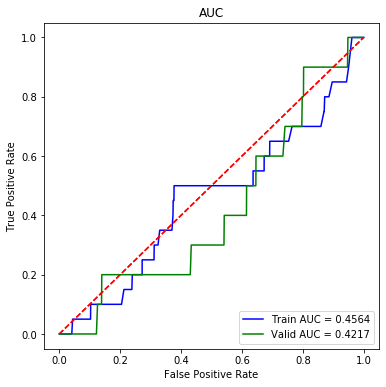

In [46]:
ax = buildROC(y_train, train_preds, label='Train')
ax = buildROC(y_valid, valid_preds, label='Valid', color='g')

## XGB CV

In [133]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']
X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

KeyError: "['window_id'] not found in axis"

In [48]:
# %%time
# another way to calc CV, but no model is returned or retained
#
d_train = xgb.DMatrix(X, y, feature_names=train_features)

cv_scores = xgb.cv(params=params, dtrain=d_train, num_boost_round=num_round, nfold=3, stratified=True,
                    metrics=metrics, early_stopping_rounds=early_stop, verbose_eval=False,
                    callbacks=[ xgb_progressbar(num_round),])
cv_scores

,train-auc-mean,train-auc-std,train-aucpr-mean,train-aucpr-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-aucpr-mean,test-aucpr-std,test-error-mean,test-error-std
0,0.929074,0.007627,0.091384,0.004921,0.230057,0.015063,0.683392,0.010987,0.003660,0.000300,0.231020,0.013884
1,0.957098,0.004552,0.202037,0.008661,0.157711,0.007173,0.652151,0.027607,0.004213,0.000759,0.159747,0.007510
2,0.969759,0.006189,0.248318,0.020206,0.153436,0.010402,0.669007,0.022791,0.004111,0.000495,0.155693,0.011344
3,0.977025,0.003104,0.277015,0.018578,0.169464,0.004566,0.679686,0.010491,0.004112,0.000302,0.171639,0.003947
4,0.986262,0.003484,0.360545,0.027169,0.140440,0.007805,0.678031,0.015063,0.004221,0.000458,0.142772,0.008556
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635239,0.021673,0.003146,0.000147,0.002108,0.000032
496,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635139,0.021728,0.003146,0.000150,0.002108,0.000032
497,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635134,0.021668,0.003146,0.000148,0.002108,0.000032
498,1.000000,0.000000,0.999992,0.000006,0.000013,0.000007,0.635279,0.021614,0.003148,0.000146,0.002108,0.000032


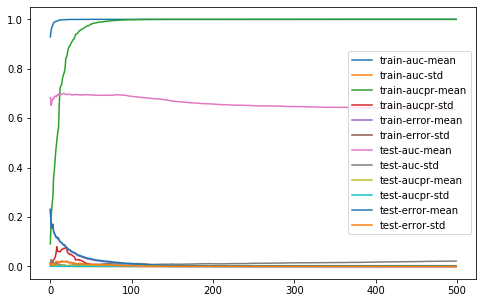

In [49]:
ax = cv_scores.plot(figsize=(8,5))

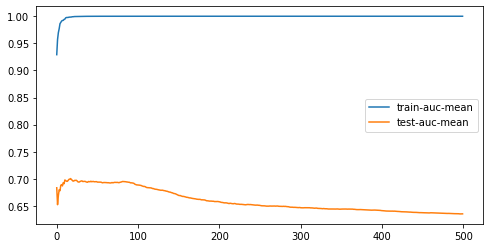

In [50]:
ax = cv_scores[['train-auc-mean','test-auc-mean']].plot(figsize=(8,4))

In [490]:
if crap is None:
    print(True)

NameError: name 'crap' is not defined

## SKLearn API

In [561]:
def xgb_progressbar(model=None, rounds=1000):
    """Progressbar for xgboost using tqdm library.
    https://programtalk.com/python-examples/tqdm/
    example: model = xgb.train(params, X_train, 1000, callbacks=[xgb_progressbar(100), ])
    """
    from tqdm.auto import tqdm
    pbar = tqdm(total=rounds)

    def callback(_, model=model):
        pbar.set_postfix(score=model.best_score, iter=model.best_iteration)
        pbar.update(1)
    
    return callback

In [541]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

clf = xgb.XGBClassifier(**params)
cv_scores={}
for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    evals_result ={}
    
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train),(X_valid, y_valid)],
            early_stopping_rounds=early_stop, verbose=False,
            callbacks=[ xgb_progressbar(xgb_model, num_round),])
    evals_result = clf.evals_result()
    evals_result['train'] = evals_result.pop('validation_0') # rename the keys
    evals_result['valid'] = evals_result.pop('validation_1')
    cv_scores[i] = {'best_score': xgb_model.best_score, 
                    'best_iteration': xgb_model.best_iteration, 
                    'best_ntree_limit': xgb_model.best_ntree_limit,
                    'evals_result': evals_result}
    
#     print("Best Score:%f, best iteration:%d, best ntree:%d" % 
#           (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

KeyboardInterrupt: 

In [156]:
# prep a df to plot the learning curve
w_df = pd.DataFrame(cv_scores)
w_df.loc['cv_av_score'] = 0
w_df.loc['cum_size'] = 0

In [159]:
w_df

,0,1,2
best_score,0.52922,0.52922,0.52922
best_iteration,122,122,122
best_ntree_limit,123,123,123
evals_result,"{'train': {'aucpr': [0.005729, 0.005829, 0.006...","{'train': {'aucpr': [0.00643, 0.00643, 0.00668...","{'train': {'aucpr': [0.005621, 0.006221, 0.006..."
cv_av_score,0,0,0
cum_size,0,0,0


122 123


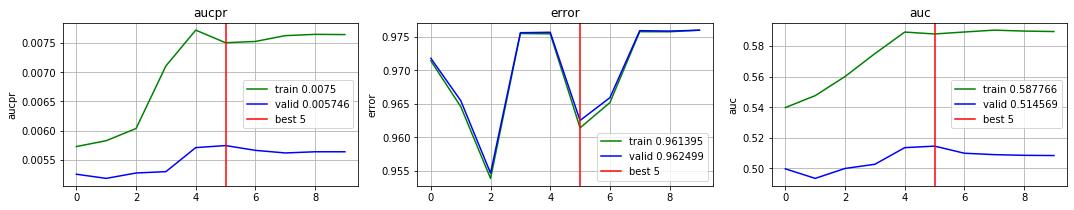

122 123


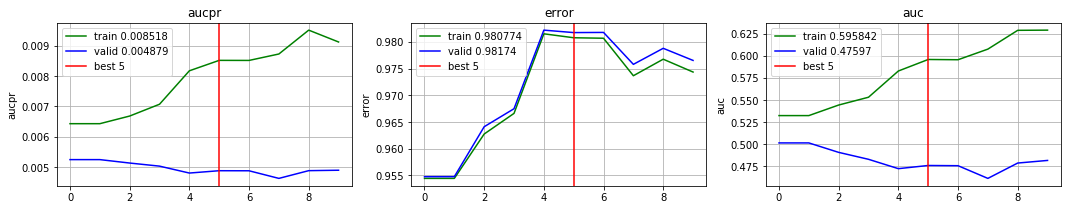

122 123


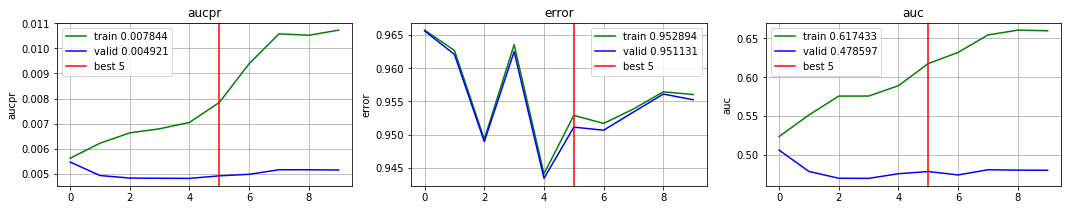

In [166]:
for s in w_df.columns:
    print(w_df.loc['best_iteration',s], w_df.loc['best_ntree_limit',s])
    plot_perf(w_df.loc['evals_result',s], 5)

## Train on StratifiedShuffleSPlit 20%

In [333]:
# just try the first window 
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

xgb_model = None
evals_result ={}
# Convert our data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [334]:
xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                          evals=watchlist, evals_result=evals_result, 
                          early_stopping_rounds=early_stop, verbose_eval=False,
                          callbacks=[ xgb_progressbar(num_round),])

In [335]:
print("Best Score:%f, best iteration:%d, best ntree:%d" % 
      (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

Best Score:0.529793, best iteration:0, best ntree:1


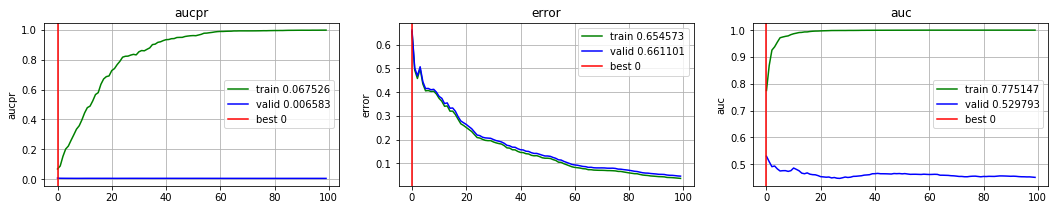

In [336]:
plot_perf(evals_result, xgb_model.best_iteration)

## RandomomizedSearchCV
 - https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [54]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [85]:
# drop_features = ['death_in_next_window', 'window_id', 'person_id']
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

In [56]:
%%time
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

space = {
    'objective':['binary:logistic'],   # in this column are values I have tried
    'booster': ['gbtree','gblinear','dart'],
    'eval_metric': ['auc'],
    'tree_method' : ['gpu_hist'],
    'random_state' : [random_state],
    'learning_rate': [0.05],           # so called `eta` value
    'reg_lambda' : [1.0],
    'min_child_weight' : [1.0],
    'max_bin' : [256],                 # [50,100,256,500]
    'min_split_loss' : [0.01],
    'max_depth' : [15],                # [10,15,20]
    'reg_alpha' : [0.0],
    'colsample_bylevel' : [1.0],
    'scale_pos_weight' : [imbalance],  # [1,round(imbalance/2),imbalance],
    'max_delta_step' : [0.0],
    'learning_rate' : [0.05],
    'n_estimators' : [1000],
    'num_parallel_tree' : [1],
    'colsample_bytree' : [0.7],        # [0.5,0.7,0.8]
    'subsample' : [1.0],               # [0.8,1.0],
    'missing': [0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
xgb_model = xgb.XGBClassifier()
# early_stopping = lambda: early_stopping_rounds=20
clf = RandomizedSearchCV(xgb_model, space, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=2, refit=True, return_train_score=True)
clf.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 83.3min remaining:    0.0s


KeyboardInterrupt: 

In [57]:
results = pd.DataFrame(clf.cv_results_['params'])
results['test_means']  = clf.cv_results_['mean_test_score']
results['test_stds']   = clf.cv_results_['std_test_score']*2
results['train_means'] = clf.cv_results_['mean_train_score']
results['train_stds']  = clf.cv_results_['std_train_score']*2
skip_col = [c for c in results.columns if len(results[c].unique()) == 1]
display(results[results.columns.difference(skip_col)].sort_values(by='test_means', ascending=False))
print("Best parameters: ", clf.best_params_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [ ]:
print("Best parameters: ", clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# pd.DataFrame([mean, stds *2])
results = pd.DataFrame(clf.cv_results_['params'])
# [c for c in results.columns if len(results[c].unique()) == 1]
skip_col = []
for c in results.columns:
    if len(results[c].unique()) == 1:  #doesn't work if c contains a list
        skip_col.append(c)

results['means'] = means
results['stds'] = stds
results[results.columns.difference(skip_col)].sort_values(by='means', ascending=False)

## SKOpt

In [28]:
# !pip install --upgrade scikit-optimize

In [391]:
import skopt
skopt.__version__

'0.7.4'

In [385]:
# X = train[train.window_id == 1]
# y = X.death_in_next_window
# X = X.drop(drop_features, axis = 1)
# train_features = X.columns.values
# X = np.array(X)
# y = np.array(y).ravel()

In [557]:
random_state = 1234
num_round = 200
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = 'auc'                  # faster with fewer metrics to calc
#metrics = ['aucpr','error', 'auc']

# gpu_hist problems: https://github.com/scikit-optimize/scikit-optimize/issues/879
   
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # gpu_hist fails with a SIGBART(-6)
    'random_state' : random_state,
}
params

{'objective': 'binary:logistic',
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'tree_method': 'gpu_hist',
 'random_state': 1234}

In [558]:
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

from skopt import BayesSearchCV
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(**params),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1, 500, 'log-uniform'),
        'missing': [OUR_NA],
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=random_state
    ),
    n_jobs = -1,
    n_iter = 8,   
    verbose = 0,
    refit = True,
    random_state = random_state
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{} Best ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
#    all_models.to_csv(clf_name+"_cv_results.csv")

In [559]:
def skopt_progressbar(model=None, rounds=100):
    """Progressbar for xgboost using tqdm library.
    https://programtalk.com/python-examples/tqdm/
    example: model = xgb.train(params, X_train, 1000, callbacks=[xgb_progressbar(100), ])
    """
    from tqdm.auto import tqdm
    pbar = tqdm(total=rounds)

    def callback(_, model=model):
        pbar.set_postfix(score=model.best_score_)
        pbar.update(1)
    
    return callback

In [560]:
result = bayes_cv_tuner.fit(X, y, callback=skopt_progressbar(bayes_cv_tuner, bayes_cv_tuner.total_iterations))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [551]:
bayes_cv_tuner

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1234, shuffle=True),
              error_score='raise',
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1, eval_metric='auc',
                                      gamma=0, learning_rate=0.1,
                                      max_delta_step=0, max_depth=3,
                                      min_child_weight=1, missing=None,
                                      n_estimators=100, n_jobs=1, nthread=N...
                             'colsample_bytree': (0.01, 1.0, 'uniform'),
                             'gamma': (1e-09, 0.5, 'log-uniform'),
                             'learning_rate': (0.01, 1.0, 'log-uniform'),
                             'max_delta_step': (0, 20), 'max_depth': (0, 50),
                             'min_child_weight': (0, 5), 'missing': [-999],
    

In [476]:
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

from skopt import BayesSearchCV
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(**params),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1, 500, 'log-uniform'),
        'missing': [OUR_NA],
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=random_state
    ),
    n_jobs = -1,
    n_iter = 8,   
    verbose = 0,
    refit = True,
    random_state = random_state
)

# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

def status_print(optim_result):
    """
    Status callback during bayesian hyperparameter search
    """
    print('Model #{} Best ROC-AUC: {}\nBest params: {}\n'.format(
        len(bayes_cv_tuner.cv_results_[list(bayes_cv_tuner.cv_results_.keys())[0]]),
        np.round(bayes_cv_tuner.best_score_, 4),
    ))

print('total space: ',bayes_cv_tuner.total_iterations)

In [477]:
bayes_cv_tuner.total_iterations

104

In [388]:
# Fit the model
# Fails at model 10 with: ValueError: All integer values shouldbe greater than 0.000000
result = bayes_cv_tuner.fit(X, y, callback=status_print)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #1 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #2 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #3 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #4 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #5 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #6 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #7 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.8s finished


Model #8 Best ROC-AUC: 0.5157
Best params: OrderedDict([('colsample_bylevel', 0.417322896138908), ('colsample_bytree', 0.9051691017946866), ('gamma', 4.130828170307698e-08), ('learning_rate', 0.4685157092356401), ('max_delta_step', 14), ('max_depth', 48), ('min_child_weight', 2), ('missing', -999), ('n_estimators', 95), ('reg_alpha', 7.248913577307237e-08), ('reg_lambda', 420), ('scale_pos_weight', 28), ('subsample', 0.6151636630785935)])



In [425]:
result

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1234, shuffle=True),
              error_score='raise',
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1, eval_metric='auc',
                                      gamma=0, learning_rate=0.1,
                                      max_delta_step=0, max_depth=3,
                                      min_child_weight=1, missing=None,
                                      n_estimators=100, n_jobs=1, nthread=N...
                             'colsample_bytree': (0.01, 1.0, 'uniform'),
                             'gamma': (1e-09, 0.5, 'log-uniform'),
                             'learning_rate': (0.01, 1.0, 'log-uniform'),
                             'max_delta_step': (0, 20), 'max_depth': (0, 50),
                             'min_child_weight': (0, 5), 'missing': [-999],
    

In [426]:
all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)

In [444]:
bayes_cv_tuner.best_score_

0.5157050367198603

In [435]:
cols = list(all_models.columns)
cols.remove('params')

In [436]:
all_models.sort_values(by='rank_test_score')[cols]

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,...,param_learning_rate,param_max_delta_step,param_max_depth,param_min_child_weight,param_missing,param_n_estimators,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample
0,0.517182,0.518651,0.511282,0.515705,0.003185,1,54.855697,0.588846,0.558139,0.002717,...,0.468516,14,48,2,-999,95,7.248914e-08,420,28,0.615164
2,0.517029,0.539002,0.489788,0.515273,0.020130,2,13.311681,0.043277,0.349582,0.004192,...,0.450233,3,28,3,-999,99,1.909546e-05,383,121,0.068866
1,0.494839,0.533989,0.506682,0.511837,0.016393,3,18.858306,0.361788,0.492716,0.003965,...,0.953252,13,26,2,-999,97,1.483516e-08,49,446,0.999087
7,0.521965,0.498532,0.512668,0.511055,0.009634,4,54.679395,1.747163,0.575803,0.010803,...,0.054572,13,40,3,-999,72,6.134573e-03,200,223,0.943281
5,0.499635,0.510206,0.508986,0.506276,0.004722,5,37.559738,0.251040,0.427398,0.004844,...,0.107698,5,45,3,-999,69,1.963257e-01,276,232,0.423430
6,0.500942,0.510339,0.499031,0.503437,0.004942,6,25.363609,0.657958,0.481435,0.010056,...,0.014382,18,44,3,-999,75,2.941050e-07,649,265,0.959583
3,0.513289,0.489666,0.486426,0.496460,0.011973,7,20.910722,0.085832,0.355779,0.005164,...,0.728815,2,8,2,-999,84,1.585282e-07,372,74,0.493035
4,0.494749,0.478447,0.508667,0.493954,0.012350,8,33.798199,0.168420,0.445114,0.007245,...,0.213963,5,34,0,-999,58,9.094392e-03,460,160,0.520434


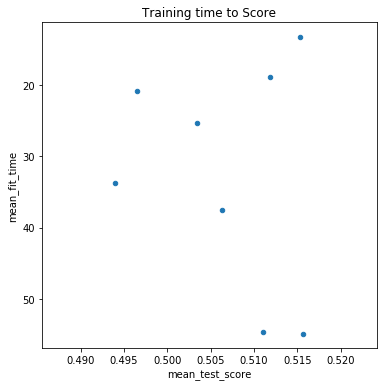

In [452]:
ax = all_models.plot.scatter(x='mean_test_score',y='mean_fit_time', figsize=(6,6), title='Training time to Score')
ax.invert_yaxis()

In [ ]:
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

from skopt import BayesSearchCV
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(**params),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1, 500, 'log-uniform'),
        'missing': [OUR_NA],
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=random_state
    ),
    n_jobs = -1,
    n_iter = 8,   
    verbose = 1,
    refit = True,
    random_state = random_state
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{} Best ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
#    all_models.to_csv(clf_name+"_cv_results.csv")

In [403]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

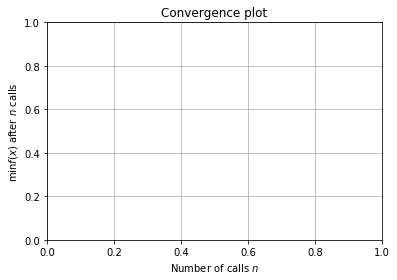

In [399]:
ax = plot_convergence(result)

In [401]:
ax = plot_evaluations(result, bins=10)

AttributeError: 'BayesSearchCV' object has no attribute 'space'

In [405]:
_ = plot_objective(result)

AttributeError: 'BayesSearchCV' object has no attribute 'space'

## Hyperopt

In [59]:
# !pip install hyperopt

In [27]:
from hyperopt.plotting import main_plot_history, main_plot_histogram
from hyperopt import hp, fmin, atpe, tpe, Trials, STATUS_OK, STATUS_FAIL
from sklearn.metrics import roc_auc_score, auc

In [28]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
imbalance

499

In [55]:
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# XGB parameters
xgb_clf_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method' : 'hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'learning_rate':    0.05, # hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(10, 30, 10, dtype=int)),
#    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
#    'subsample':        hp.uniform('subsample', 0.8, 1),
#    'n_estimators':     400,
    'scale_pos_weight' : hp.choice('scale_pos_weight', [1,10,round(imbalance/2), imbalance]),

}

xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 20,
    'verbose': False
}
xgb_para = dict()
xgb_para['clf_params'] = xgb_clf_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: 1.0-roc_auc_score(y, pred)

In [49]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        clf = xgb.XGBClassifier(**para['clf_params'])
        return self.train_clf(clf, para)

    def train_clf(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [50]:
# just try the first window 
X = train
y = X.death_in_next_window
X = X.drop(drop_features, axis = 1)
train_features = X.columns.values
X = np.array(X)
y = np.array(y).ravel()

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [51]:
obj = HPOpt(X_train, X_valid, y_train, y_valid)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=4)

100%|██████████| 4/4 [01:08<00:00, 17.13s/trial, best loss: 0.4889537628009112] 


avg best error: 0.4889537628009112


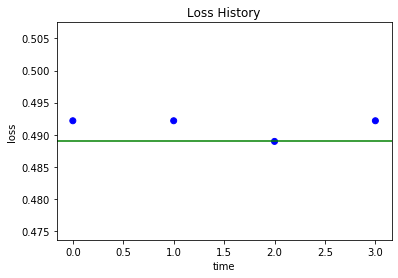

In [52]:
main_plot_history(xgb_opt[1])

Showing Histogram of 4 jobs


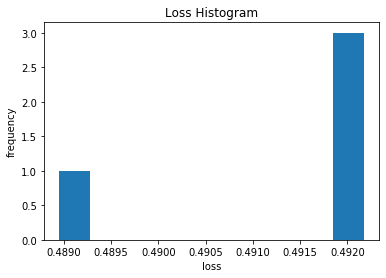

In [53]:
main_plot_histogram(xgb_opt[1])

In [54]:
xgb_opt

({'scale_pos_weight': 1}, <hyperopt.base.Trials at 0x7f5529374090>)

In [67]:
# # Define objective function
# def objective(x):
#     return {'loss': 1 - auc, 'status': STATUS_OK}

# # Run hyperopt optimization
# trials = Trials()
# result = fmin(
#     fn=objective,               
#     space=hp.uniform('x', -1, 1),   # parameter space
#     algo=tpe.suggest,               # surrogate algorithm
#     max_evals=500,                  # no. of evaluations
#     trials=trials                   # trials object that keeps track of the sample results (optional)
# )

# # Print the optimized parameters
# print(result)

# # Extract and plot the trials 
# x = trials.vals['x']
# y = [x['loss'] for x in trials.results]
# plt.scatter(x, y)

## ROC AUC Curve

In [68]:
# X = train.drop(drop_features, axis = 1)
# train_features = X.columns.values
# y = train[['death_in_next_window']]
# X = np.array(X)
# y = np.array(y).ravel()

In [82]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [35]:
# Convert data into XGBoost format
d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
d_valid = xgb.DMatrix(X_valid, y_valid, feature_names=train_features)

In [101]:
best_tree = xgb_model.best_ntree_limit
best_tree = 16
train_preds = xgb_model.predict(d_train, ntree_limit=best_tree)
valid_preds = xgb_model.predict(d_valid, ntree_limit=best_tree)

In [102]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import plot_roc_curve  # only sklearn after version 0.22 
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [103]:
print('Train AUC =',roc_auc_score(y_train, train_preds))
print('Valid AUC =',roc_auc_score(y_valid, valid_preds))

Train AUC = 0.4511737200075571
Valid AUC = 0.50912638469285


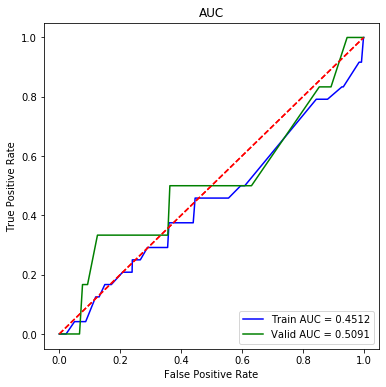

In [105]:
ax = buildROC(y_train, train_preds, label='Train')
ax = buildROC(y_valid, valid_preds, label='Valid', color='g')

## Feature Importance

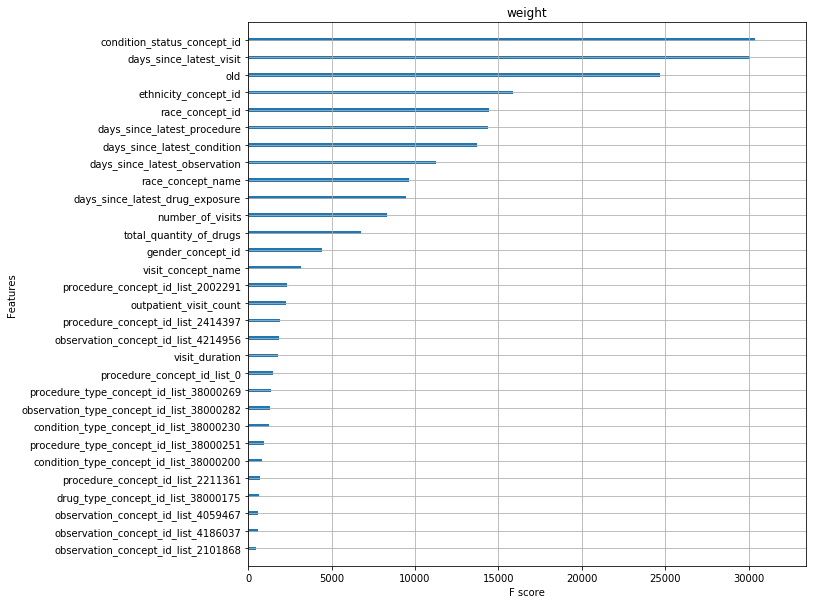

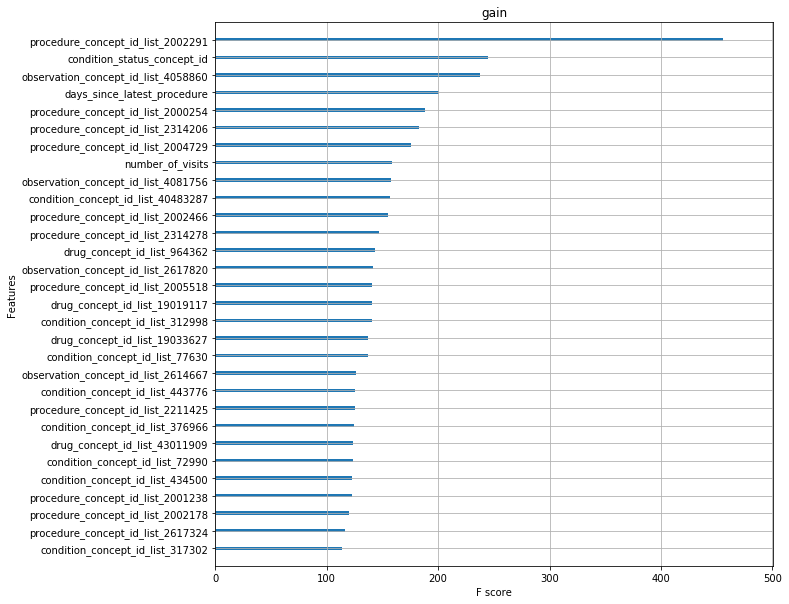

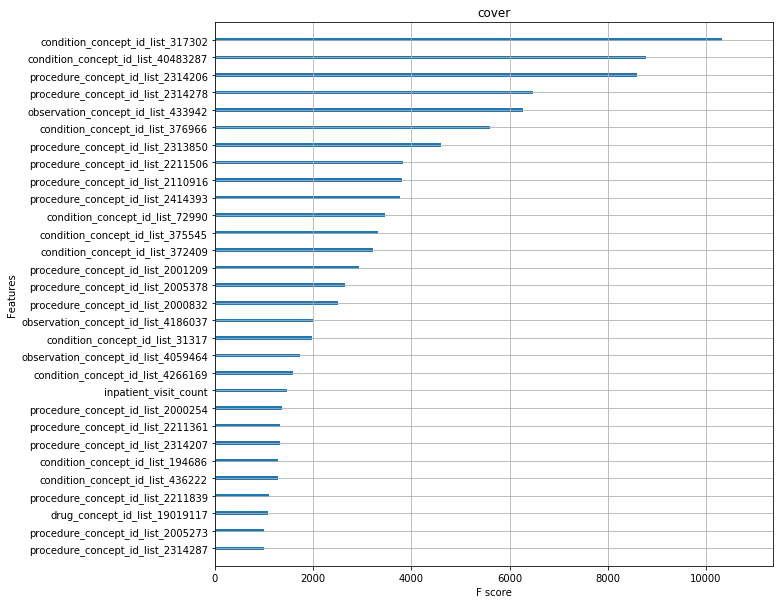

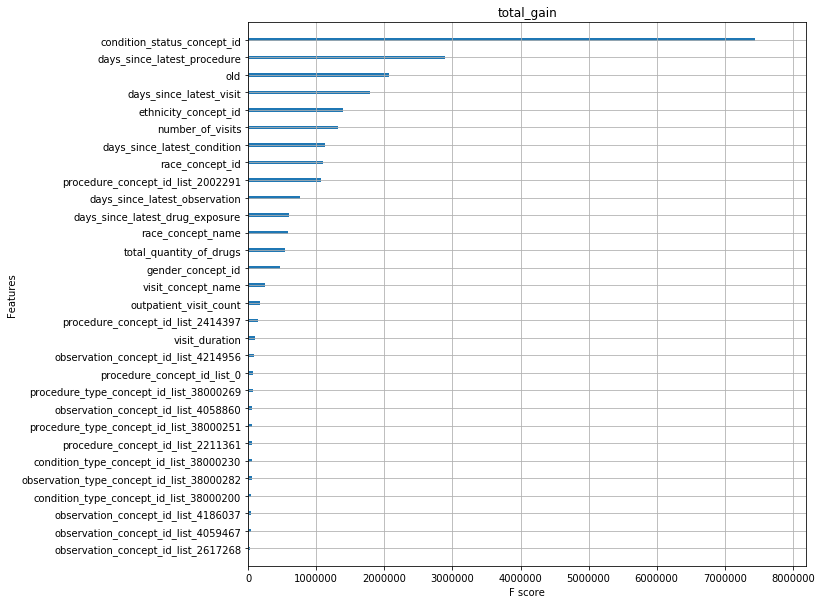

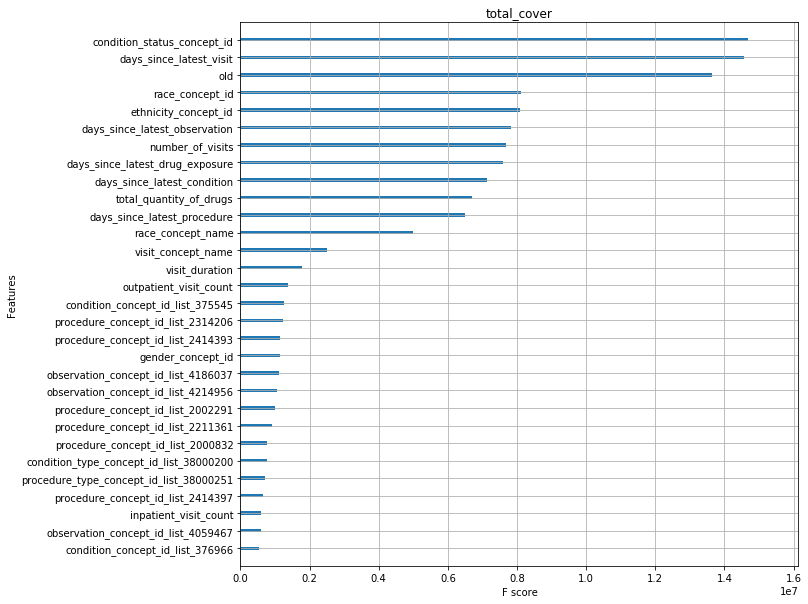

In [51]:
plt.rcParams["figure.figsize"] = (10,10)
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for i in importance_types:
    ax = xgb.plot_importance(xgb_model, importance_type=i, max_num_features=30, title=i, show_values=False)

In [52]:
for idx, i in enumerate(importance_types):
    i_dict = xgb_model.get_score(importance_type=i)
    i_df = pd.DataFrame.from_dict(i_dict.items())
    i_df.columns=['feature',i]
    if idx == 0:
        importance = i_df
    else:
        importance = importance.combine_first(i_df) #, on='feature', how='outer', suffixes=(False, False))

importance = importance.set_index('feature')
importance = importance[importance_types]
importance = importance.sort_values(by='weight', ascending=False)
importance = importance.round(2)
importance.head(10)

,weight,gain,cover,total_gain,total_cover
feature,,,,,
condition_status_concept_id,30409,245.03,482.54,7451164.58,14673701.39
days_since_latest_visit,30082,59.48,484.55,1789244.72,14576340.37
old,24688,83.98,552.02,2073413.59,13628273.03
ethnicity_concept_id,15867,88.05,509.64,1397093.22,8086394.43
race_concept_id,14451,76.47,562.34,1105041.44,8126337.56
days_since_latest_procedure,14402,200.51,450.96,2887795.33,6494759.82
days_since_latest_condition,13701,82.07,521.50,1124378.09,7145067.85
days_since_latest_observation,11238,68.26,695.47,767092.07,7815706.19
race_concept_name,9648,60.78,517.69,586437.63,4994661.37


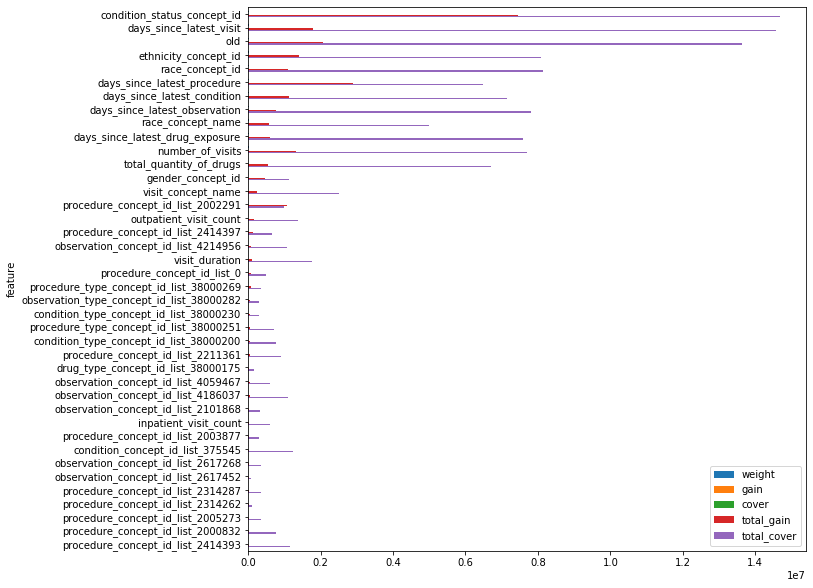

In [53]:
ax = importance[:40].plot.barh()
ax.invert_yaxis()

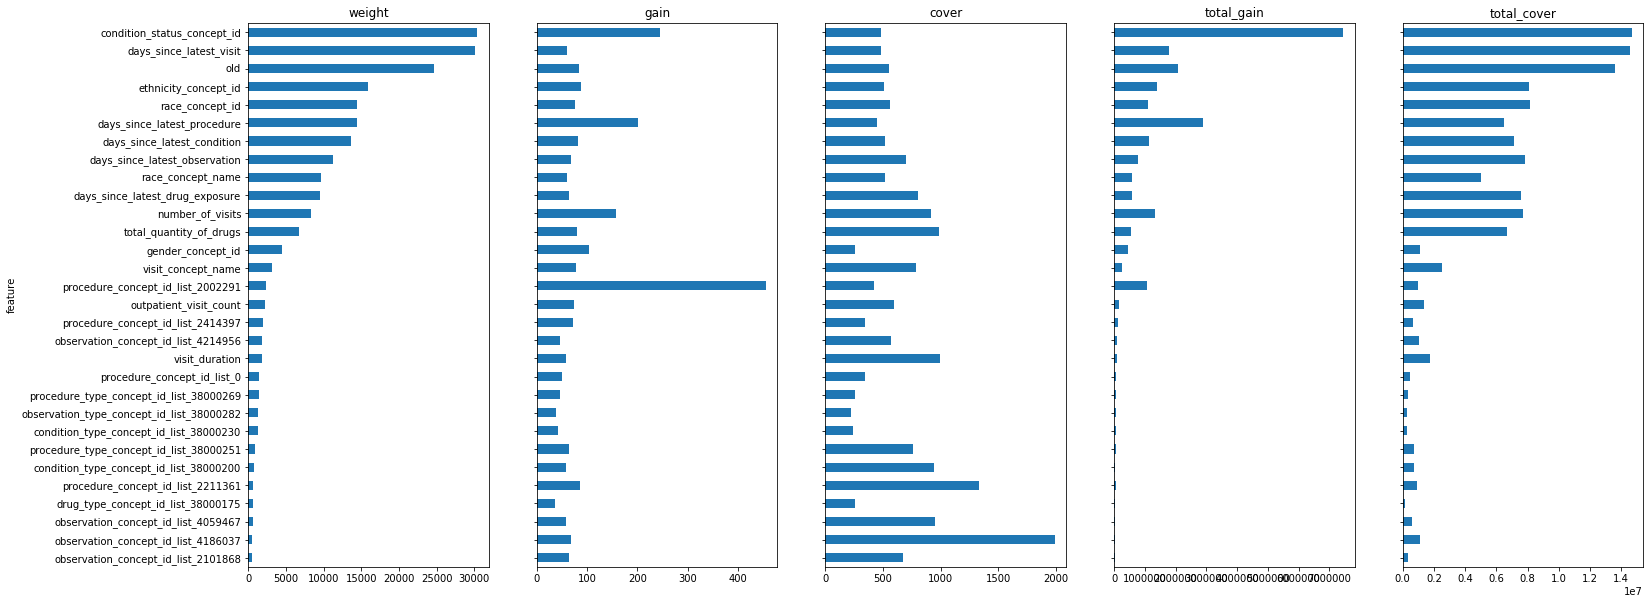

In [54]:
fig, axs = plt.subplots(1, len(importance_types), sharey=True, figsize=(len(importance_types)*5,10))
for idx, i in enumerate(importance_types):
    importance[i][:30].plot.barh(title=i, ax=axs[idx])
    axs[idx].invert_yaxis()
plt.show()

In [55]:
importance = importance.join(col_concepts.set_index('column'),how='left') #.sort_values(by='weight', ascending=False)
importance[:50]

NameError: name 'col_concepts' is not defined

In [81]:
observation = pd.read_csv('v2/app/concept_codes_final/observation_concepts.csv')
observation.head()

,observation_concept_id,concept_name,vocabulary_id
0,313232,Hemodialysis-associated hypotension,SNOMED
1,432454,Excessive thirst,SNOMED
2,141693,Elevated blood-pressure reading without diagno...,SNOMED
3,379831,Unilateral neural hearing loss,SNOMED
4,433496,Unilateral sensory hearing loss,SNOMED


In [82]:
observation[observation.observation_concept_id == 4058860]

,observation_concept_id,concept_name,vocabulary_id


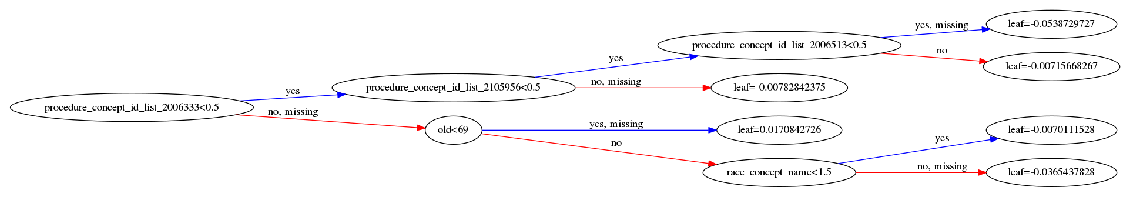

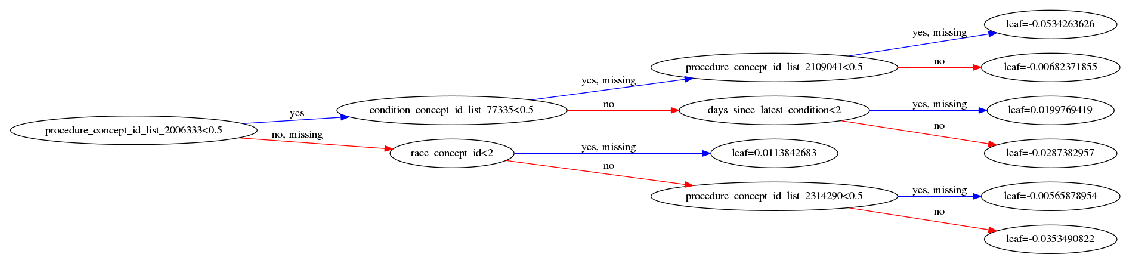

In [424]:
plt.rcParams["figure.figsize"] = (20,40)
for k in range(30,32):
    ax = xgb.plot_tree(xgb_model,num_trees=k, rankdir='LR')
    plt.show()

In [414]:
raise Exception('STOP HERE - NOTHING WORKS PAST THIS POINT')

Exception: STOP HERE - NOTHING WORKS PAST THIS POINT

## SHAP explanations - doesn't work, tree too big
-  https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [103]:
# # # !pip install shap
# import shap
# shap.__version__

'0.34.0'

In [104]:
# X = train[train.window_id == w] #[train.columns[:50]]
# y = X.death_in_next_window
# X = X.drop(drop_features, axis = 1)
# train_features = X.columns.values
# X = np.array(X)
# y = np.array(y).ravel()

In [1]:
# explainer = shap.TreeExplainer(xgb_model)

In [2]:
# shap_values = explainer.shap_values(X)

In [5]:
# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

## LGBM

In [167]:
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = 'auc'                   # faster with fewer metrics to calc
# metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'learning_rate': 0.05,
    'is_unbalance': True,
    'class_weight': 'balanced'    
}


In [168]:
# https://scikit-learn.org/stable/modules/calibration.html

In [169]:
window = {}
xgb_model = None # clear out the xgb_model
for w in train.window_id.unique():
    X = train[train.window_id == w] #[train.columns[:50]]
    y = X.death_in_next_window
    window[w] = {'size': y.shape[0], 'deaths': y.sum()}
    X = X.drop(drop_features, axis = 1)
    train_features =list(X.columns)
    categorical_feature=list(range(16,len(train.columns)))
    X = np.array(X)
    y = np.array(y).ravel()
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    cv_scores = {}
    for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        evals_result ={}
        # Convert our data into XGBoost format
#         d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
#         d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
    break

/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/user/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 1

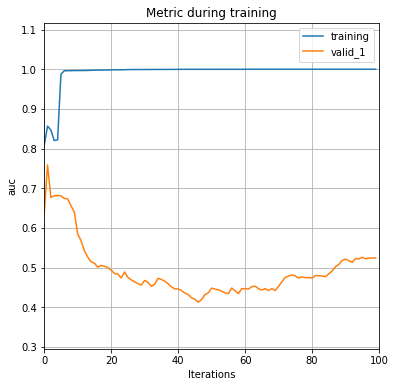

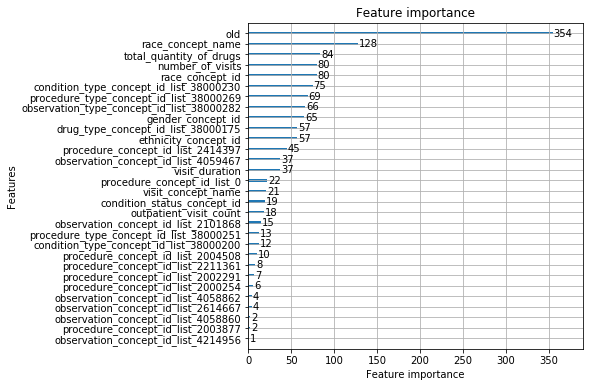

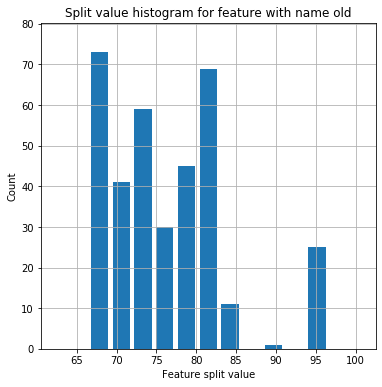

In [173]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, feature_name=train_features, categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'task': 'train',
    'device': 'gpu',
    'metric': ['binary_logloss','auc'],
    'n_estimators': 100,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 0
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params,
                lgb_train,
#                num_boost_round=100,
                valid_sets=[lgb_train, lgb_valid],
                evals_result=evals_result,
                early_stopping_rounds=early_stop,
                verbose_eval=0)

ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

ax = lgb.plot_split_value_histogram(gbm, feature='old', bins='auto')
plt.show()

# print('Plotting 54th tree...')  # one tree use categorical feature to split
# ax = lgb.plot_tree(gbm, tree_index=53, figsize=(15, 15), show_info=['split_gain'])
# plt.show()

# print('Plotting 54th tree with graphviz...')
# graph = lgb.create_tree_digraph(gbm, tree_index=53, name='Tree54')
# graph.render(view=True)


In [178]:
gbm.best_iteration

100

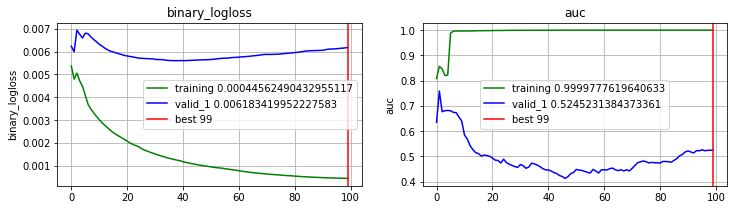

In [179]:
plot_perf(evals_result, gbm.best_iteration-1)

In [109]:
# import lightgbm as lgb

# params = {
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'n_estimators': 20,
# }

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': ['binary_logloss','auc'],
#     'n_estimators': 20,
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 1
# }

# gbm = lgb.LGBMClassifier(**params)

# gbm.fit(X_train, y_train,
#         eval_set=[(X_train, y_train),(X_valid, y_valid)],
# #        eval_metric='auc',
#         early_stopping_rounds=10)

# print('Starting predicting...')
# # predict
# y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
# # eval
# print('AUC: ', roc_auc_score(y_valid, y_pred))


## Eval Test 

In [107]:
# Predict on test data
d_test = xgb.DMatrix(X_test, y_test, feature_names=train_features)
preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [108]:
y_scores = preds

In [109]:
print('AUC =',roc_auc_score(y_test.values, y_scores))

AUC = 0.5728509210265466


In [110]:
average_precision = average_precision_score(y_test, y_scores)
print('PRAUC = ', average_precision)

PRAUC =  0.0019102585253601625


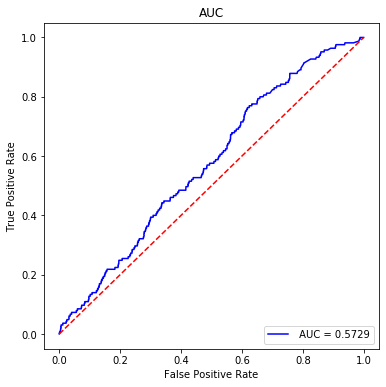

In [111]:
buildROC(y_test.values, preds, label='')

In [72]:
# # only good with sklearn API

# fig, ax = plt.subplots()
# plot_roc_curve(xgb_model, X_test, y_test, ax=ax)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="AUC")
# ax.legend(loc="lower right")
# plt.show()

In [65]:
# import scikitplot as skplt
# plt.rcParams["figure.figsize"] = (10,10)
# skplt.metrics.plot_roc(y_test, preds)

## Full train

In [46]:
# select features
drop_features = ['death_in_next_window', 'window_id', 'person_id']

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train.death_in_next_window
X = np.array(X)
y = np.array(y).ravel()

In [53]:
len(y)

278998

In [54]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 79
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 15,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 500,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': 0,
}

In [63]:
d_train_full = xgb.DMatrix(X, y, feature_names=train_features)
xgb_model = xgb.train(params, d_train_full, num_boost_round=num_round, maximize=True, 
                      verbose_eval=False, callbacks=[xgb_progressbar(num_round), ])

In [58]:
d_test = xgb.DMatrix(X_test, y_test, feature_names=test_features)
train_preds = xgb_model.predict(d_train_full, ntree_limit=xgb_model.best_ntree_limit)
test_preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

In [60]:
print('Train AUC =',roc_auc_score(y, train_preds))
print('Valid AUC =',roc_auc_score(y_test, test_preds))

Train AUC = 0.9820409272365556
Valid AUC = 0.5887798620861614


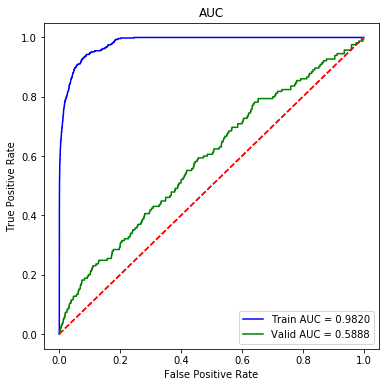

In [62]:
ax = buildROC(y, train_preds, label='Train')
ax = buildROC(y_test, test_preds, label='Valid', color='g')

## Test saving and loading the model

In [64]:
model_file = 'xgb_model.joblib'
dump(xgb_model, model_file)

['xgb_model.joblib']

In [65]:
xgb_model_2 = load(model_file)
type(xgb_model_2)

xgboost.core.Booster

In [18]:
raise # stop here

RuntimeError: No active exception to reraise

## ROC AUC CV

In [134]:
# select features
drop_features = ['death_in_next_window', 'person_id'] # 'window_id', 

X = train.drop(drop_features, axis = 1)
train_features = X.columns.values
y = train[['death_in_next_window']]
X = np.array(X)
y = np.array(y).ravel()

In [45]:
imbalance = int(round(train.shape[0] / train.death_in_next_window.sum()))
random_state = 1234
num_round = 500
early_stop = round(num_round / 5)  # 20% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 1000,
    'min_split_loss' : 0.01,
    'max_depth' : 3,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.7,
    'subsample' : 1.0,
    'missing': OUR_NA,
}

In [169]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

Best Score:0.529220, best iteration:122, best ntree:123



Best Score:0.529220, best iteration:122, best ntree:123



Best Score:0.529220, best iteration:122, best ntree:123



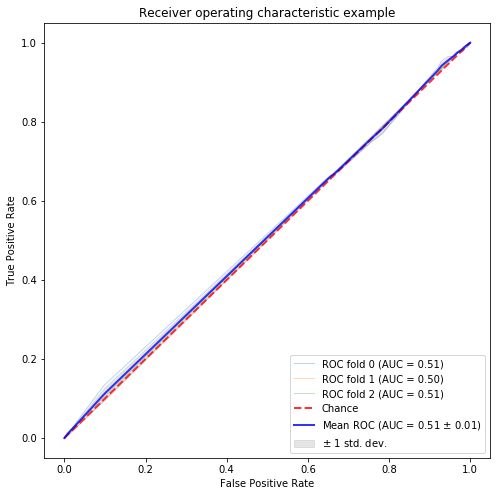

CPU times: user 3.95 s, sys: 404 ms, total: 4.36 s
Wall time: 4.35 s


In [173]:
%%time
from sklearn.model_selection import StratifiedKFold
splits=3
cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(8,8))

clf = xgb.XGBClassifier(**params)
cv_scores={}
for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    evals_result ={}
    
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train),(X_valid, y_valid)],
            early_stopping_rounds=early_stop, verbose=False,
            callbacks=[ xgb_progressbar(num_round),])
    evals_result = clf.evals_result()
    evals_result['train'] = evals_result.pop('validation_0') # rename the keys
    evals_result['valid'] = evals_result.pop('validation_1')
    cv_scores[i] = {'best_score': xgb_model.best_score, 
                    'best_iteration': xgb_model.best_iteration, 
                    'best_ntree_limit': xgb_model.best_ntree_limit,
                    'evals_result': evals_result}
    viz = plot_roc_curve(clf, X_valid, y_valid,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    print("Best Score:%f, best iteration:%d, best ntree:%d" % 
          (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [286]:
for c in cv_scores:
    print(cv_scores[c]['evals_result'])

{'train': {'aucpr': [0.005729, 0.005829, 0.006037, 0.007104, 0.007715, 0.0075, 0.007522, 0.007621, 0.007643, 0.007639], 'error': [0.971399, 0.964582, 0.953843, 0.975489, 0.975443, 0.961395, 0.965164, 0.975765, 0.975749, 0.975995], 'auc': [0.539719, 0.547518, 0.559989, 0.574947, 0.588999, 0.587766, 0.589049, 0.590269, 0.589652, 0.589355]}, 'valid': {'aucpr': [0.005257, 0.005186, 0.005278, 0.005301, 0.005711, 0.005746, 0.005664, 0.00562, 0.00564, 0.00564], 'error': [0.971782, 0.965471, 0.954625, 0.975612, 0.975673, 0.962499, 0.9659, 0.975918, 0.975857, 0.97598], 'auc': [0.499746, 0.493511, 0.499986, 0.502721, 0.513571, 0.514569, 0.50992, 0.509014, 0.508563, 0.508416]}}
{'train': {'aucpr': [0.00643, 0.00643, 0.006682, 0.007071, 0.008174, 0.008518, 0.008516, 0.008728, 0.009515, 0.009124], 'error': [0.954456, 0.954456, 0.962759, 0.966619, 0.98151, 0.980774, 0.980682, 0.973666, 0.976761, 0.974355], 'auc': [0.532392, 0.532392, 0.544337, 0.553163, 0.582809, 0.595842, 0.595558, 0.607566, 0.6288

In [288]:
# prep a df to plot the learning curve
new_scores = cv_scores.copy()
evals_result = cv_scores[0]['evals_result']
for e in cv_scores:
    evals_result = cv_scores[e]['evals_result']
    evals_df = pd.DataFrame.from_dict({(i,j): evals_result[i][j] 
                           for i in evals_result.keys() 
                           for j in evals_result[i].keys()})
    new_scores[e]['evals_result'] = evals_df
    

In [277]:
evals_df[0,'best_score',0] = cv_scores[0]['best_score']

In [299]:
folds = [0,1,2]
new_scores[folds]['evals_result']['train','auc']

TypeError: unhashable type: 'list'

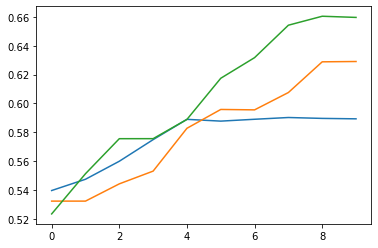

In [292]:
for c in new_scores:
    ax=new_scores[c]['evals_result']['train','auc'].plot()

In [280]:
# prep a df to plot the learning curve
evals_result = cv_scores[0]['evals_result']
evals_df = pd.DataFrame.from_dict({(k, i,j): cv_scores[k]['evals_result'][i][j] 
                                   for k in cv_scores
                                   for i in cv_scores[k]['evals_result'].keys() 
                                   for j in cv_scores[k]['evals_result'][i].keys()})
#                       orient='index')


0         1         2         3         4  \
0 best_score 0      0.529220  0.529220  0.529220  0.529220  0.529220   
  train      auc    0.539719  0.547518  0.559989  0.574947  0.588999   
             aucpr  0.005729  0.005829  0.006037  0.007104  0.007715   
             error  0.971399  0.964582  0.953843  0.975489  0.975443   
  valid      auc    0.499746  0.493511  0.499986  0.502721  0.513571   
             aucpr  0.005257  0.005186  0.005278  0.005301  0.005711   
             error  0.971782  0.965471  0.954625  0.975612  0.975673   
1 train      auc    0.532392  0.532392  0.544337  0.553163  0.582809   
             aucpr  0.006430  0.006430  0.006682  0.007071  0.008174   
             error  0.954456  0.954456  0.962759  0.966619  0.981510   
  valid      auc    0.501492  0.501492  0.490799  0.482961  0.472387   
             aucpr  0.005245  0.005245  0.005132  0.005030  0.004802   
             error  0.954778  0.954778  0.964123  0.967493  0.982199   
2 train      auc    0.523530  0.551363  0.575603  0.575626  0.588944   
             aucpr  0.005621  0.006221  0.006634  0.006796  0.007050   
             error  0.965685  0.962637  0.949324  0.963510  0.944116   
  valid      auc    0.506116  0.478693  0.469959  0.469800  0.475799   
             aucpr  0.005472  0.004934  0.004833  0.004825  0.004820   
             error  0.965562  0.962038  0.948955  0.962467  0.943440   

                           5         6         7         8         9  
0 best_score 0      0.529220  0.529220  0.529220  0.529220  0.529220  
  train      auc    0.587766  0.589049  0.590269  0.589652  0.589355  
             aucpr  0.007500  0.007522  0.007621  0.007643  0.007639  
             error  0.961395  0.965164  0.975765  0.975749  0.975995  
  valid      auc    0.514569  0.509920  0.509014  0.508563  0.508416  
             aucpr  0.005746  0.005664  0.005620  0.005640  0.005640  
             error  0.962499  0.965900  0.975918  0.975857  0.975980  
1 train      auc    0.595842  0.595558  0.607566  0.628816  0.629036  
             aucpr  0.008518  0.008516  0.008728  0.009515  0.009124  
             error  0.980774  0.980682  0.973666  0.976761  0.974355  
  valid      auc    0.475970  0.475729  0.461382  0.478729  0.481683  
             aucpr  0.004879  0.004877  0.004626  0.004881  0.004895  
             error  0.981740  0.981770  0.975796  0.978798  0.976531  
2 train      auc    0.617433  0.631716  0.654164  0.660366  0.659556  
             aucpr  0.007844  0.009388  0.010576  0.010521  0.010725  
             error  0.952894  0.951684  0.953859  0.956432  0.956019  
  valid      auc    0.478597  0.474247  0.480901  0.480409  0.480218  
             aucpr  0.004921  0.004983  0.005164  0.005164  0.005153  
             error  0.951131  0.950671  0.953398  0.956094  0.955236

In [256]:
cv_df = pd.DataFrame(cv_scores).T
evals_l=[]
for i, r in cv_df.iterrows():
    evals_result = cv_df.loc[i,'evals_result']
    evals_df = pd.DataFrame.from_dict({(i,j): evals_result[i][j] 
                           for i in evals_result.keys() 
                           for j in evals_result[i].keys()})
    evals_l.append(evals_df)

In [296]:
pd.concat(evals_l,keys=[0,1,2]).T.loc[('train','auc'),:]

0  0    0.539719
   1    0.547518
   2    0.559989
   3    0.574947
   4    0.588999
   5    0.587766
   6    0.589049
   7    0.590269
   8    0.589652
   9    0.589355
1  0    0.532392
   1    0.532392
   2    0.544337
   3    0.553163
   4    0.582809
   5    0.595842
   6    0.595558
   7    0.607566
   8    0.628816
   9    0.629036
2  0    0.523530
   1    0.551363
   2    0.575603
   3    0.575626
   4    0.588944
   5    0.617433
   6    0.631716
   7    0.654164
   8    0.660366
   9    0.659556
Name: (train, auc), dtype: float64

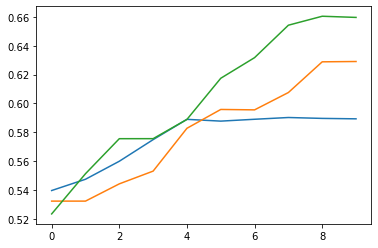

In [298]:
all={}
all['auc'] = pd.concat(evals_l,keys=[0,1,2]).T.loc[('train','auc'),:]
for j in [0,1,2]:
    all['auc'][j].plot()
all['auc']

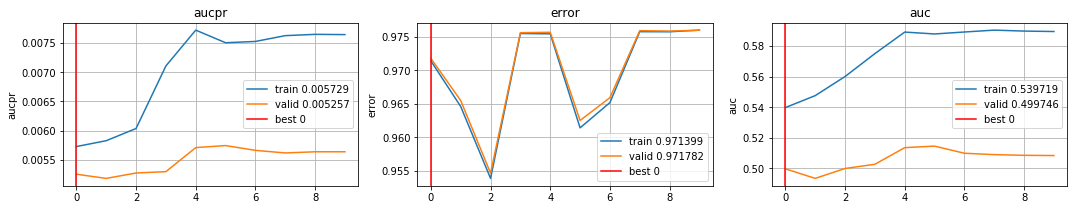

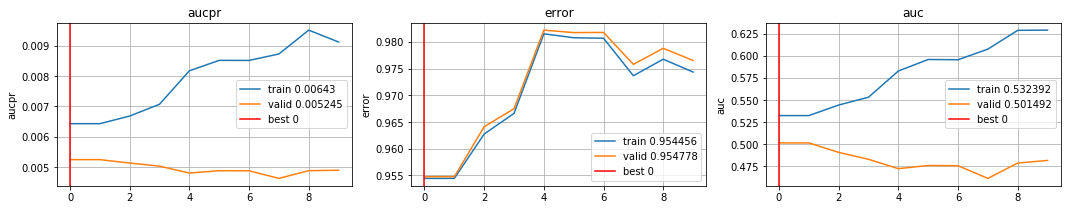

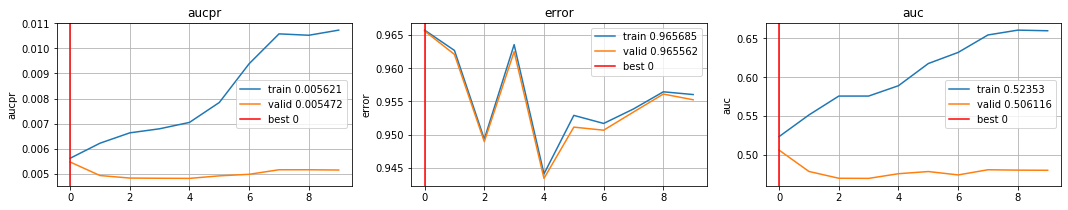

In [207]:
for s in w_df.columns:
    plot_perf(w_df.loc['evals_result',s], 0)

In [240]:
w_df

,0,1,2
best_score,0.52922,0.52922,0.52922
best_iteration,122,122,122
best_ntree_limit,123,123,123
evals_result,"{'train': {'aucpr': [0.005729, 0.005829, 0.006...","{'train': {'aucpr': [0.00643, 0.00643, 0.00668...","{'train': {'aucpr': [0.005621, 0.006221, 0.006..."


In [206]:
def plot_perf(evals_result, best):
    ''' 
    plot all model performance metrics over epochs
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    '''
    import matplotlib.cm as cm
    from sklearn.metrics import auc
    from sklearn.metrics import plot_roc_curve
    x = np.arange(10)  # 10 should be range of keys
    ys = [i+x+(i*x)**2 for i in range(10)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    keys = list(evals_result.keys())
    metrics = list(evals_result[keys[0]].keys())
    epochs = len(evals_result[keys[0]][metrics[0]])
    num_plots = len(metrics)
    x_axis = list(range(0, epochs))
    fig, axs = plt.subplots(1, num_plots, figsize=(6*num_plots,3))
    if num_plots == 1: # in the case there is only one metric, then subplot doesn't return a list of ax's, so we create one
        axs = [axs]
    for p in range(num_plots):
        for i, k in enumerate(keys):
            axs[p].plot(x_axis, evals_result[k][metrics[p]], 
                        label=k+' '+str(evals_result[k][metrics[p]][best]))
        axs[p].ticklabel_format(useOffset=False, style='plain')
        axs[p].axvline(x=best, color='r', label='best '+str(best))
        axs[p].grid(True)
        axs[p].legend()
        axs[p].set_ylabel(metrics[p])
        axs[p].set_title(metrics[p])

    plt.show()

In [213]:
def plot_perf(cv_scores):
    ''' 
    plot all model performance metrics over epochs
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    '''
    import matplotlib.cm as cm
    from sklearn.metrics import auc
    from sklearn.metrics import plot_roc_curve
    x = np.arange(10)  # 10 should be range of keys
    ys = [i+x+(i*x)**2 for i in range(10)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    evals_result = cv_scores.loc['evals_result',0]
    keys = list(evals_result.keys())   # 'train' or 'valid' or more
    metrics = list(evals_result[keys[0]].keys())
    epochs = len(evals_result[keys[0]][metrics[0]])
    num_plots = len(metrics)
    folds = cv_scores.columns
    print(keys, metrics, epochs, folds, num_plots)

    x_axis = list(range(0, epochs))
    fig, axs = plt.subplots(1, num_plots, figsize=(6*num_plots,3))
    if num_plots == 1: 
        # in the case there is only one metric
        # subplot doesn't return a list of ax's, so we create one
        axs = [axs]
        
    for p, m in enumerate(metrics):
        for k in keys:
            for f in folds:
                evals_result=cv_scores.loc['evals_result',f]
                axs[p].plot(x_axis, evals_result[f][m], 
                            label=m+' '+str(f)) #str(evals_result[f][m][best]))
            axs[p].ticklabel_format(useOffset=False, style='plain')
            axs[p].axvline(x=best, color='r', label='best '+str(best))
            axs[p].grid(True)
            axs[p].legend()
            axs[p].set_ylabel(m)
            axs[p].set_title(m)

#         mean_tpr = np.mean(tprs, axis=0)
#         mean_tpr[-1] = 1.0
#         mean_auc = auc(mean_fpr, mean_tpr)
#         std_auc = np.std(aucs)
#         ax.plot(mean_fpr, mean_tpr, color='b',
#                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#                 lw=2, alpha=.8)

#         std_tpr = np.std(tprs, axis=0)
#         tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#         tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#         ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                         label=r'$\pm$ 1 std. dev.')

#         ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#                title="Receiver operating characteristic example")
#         ax.legend(loc="lower right")

    plt.show()

['train', 'valid'] ['aucpr', 'error', 'auc'] 10 Int64Index([0, 1, 2], dtype='int64') 3


KeyError: 0

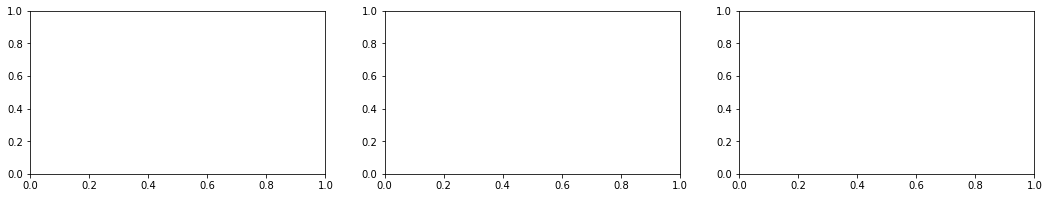

In [214]:
plot_perf(w_df)